In [1]:
!kaggle datasets download -d dansbecker/food-101

Dataset URL: https://www.kaggle.com/datasets/dansbecker/food-101
License(s): other
100% 9.36G/9.38G [02:29<00:00, 137MB/s]
100% 9.38G/9.38G [02:29<00:00, 67.4MB/s]


In [2]:
!unzip food-101.zip

Streaming output truncated to the last 5000 lines.
  inflating: food-101/food-101/images/tacos/1030289.jpg  
  inflating: food-101/food-101/images/tacos/1033196.jpg  
  inflating: food-101/food-101/images/tacos/1036030.jpg  
  inflating: food-101/food-101/images/tacos/1042175.jpg  
  inflating: food-101/food-101/images/tacos/1044043.jpg  
  inflating: food-101/food-101/images/tacos/1058697.jpg  
  inflating: food-101/food-101/images/tacos/1059239.jpg  
  inflating: food-101/food-101/images/tacos/1059326.jpg  
  inflating: food-101/food-101/images/tacos/1066762.jpg  
  inflating: food-101/food-101/images/tacos/1070967.jpg  
  inflating: food-101/food-101/images/tacos/1073468.jpg  
  inflating: food-101/food-101/images/tacos/1075296.jpg  
  inflating: food-101/food-101/images/tacos/1085243.jpg  
  inflating: food-101/food-101/images/tacos/108529.jpg  
  inflating: food-101/food-101/images/tacos/1086014.jpg  
  inflating: food-101/food-101/images/tacos/108945.jpg  
  inflating: food-101/f

In [3]:
import os
import torch
import torchvision
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torchvision import models
from torch.utils.data import DataLoader, ConcatDataset
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from torchvision.utils import make_grid
from torchsummary import summary
import matplotlib.pyplot as plt
%matplotlib inline
import time
from torch.autograd import Variable
import cv2
from PIL import Image
from pathlib import Path

In [5]:
import os
from pathlib import Path
data=Path("food-101/food-101/images")
IMG_SIZE = 128
RANDOM_STATE = 42

In [6]:
import os
os.listdir(data)
os.remove(data/".DS_Store")

In [7]:
# Creating an transformer
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    # mv-move
    !rm -rf pytorch-deep-learning
    # rm-remove rf-flags r=Recursively remove,f=force removal without asking.
    from going_modular.going_modular import data_setup, engine

[INFO] Couldn't find going_modular scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4183, done.
remote: Counting objects: 100% (148/148), done.
remote: Compressing objects: 100% (107/107), done.
remote: Total 4183 (delta 65), reused 98 (delta 40), pack-reused 4035 (from 1)
Receiving objects: 100% (4183/4183), 652.89 MiB | 39.17 MiB/s, done.
Resolving deltas: 100% (2436/2436), done.
Updating files: 100% (248/248), done.


In [8]:
from torchvision.datasets import ImageFolder
data_dl=ImageFolder(data)
len(data_dl.classes)

101

In [9]:
# @title Lets create training and testing set
set_transform=transforms.Compose(
    [
        transforms.Grayscale(num_output_channels=3),#cc,l,w
        transforms.Resize((IMG_SIZE,IMG_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(30),
        transforms.ToTensor(),
    ]
)


In [10]:
import os
import shutil
from sklearn.model_selection import train_test_split
dataset_dir = 'food-101/food-101/images'# Path to the original dataset
train_dir = 'food-101/food-101/train'
test_dir = 'food-101/food-101/test'

os.makedirs(train_dir, exist_ok=True) #making directory for training set
os.makedirs(test_dir, exist_ok=True)# making directory for testing set

# Iterate through each class in the dataset
for class_name in os.listdir(dataset_dir):
    class_path = os.path.join(dataset_dir, class_name)
    if not os.path.isdir(class_path):
        continue
    images = os.listdir(class_path)# List all images in the current class directory

    train_images, test_images = train_test_split(images, test_size=0.2, random_state=42)

    # Create directories for the current class in train and test directories
    os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

    # Move training images to the train directory
    for image in train_images:
        shutil.move(os.path.join(class_path, image), os.path.join(train_dir, class_name, image))

    # Move testing images to the test directory
    for image in test_images:
        shutil.move(os.path.join(class_path, image), os.path.join(test_dir, class_name, image))

print("Dataset successfully split into training and testing sets!")


Dataset successfully split into training and testing sets!


In [11]:
data_dl=ImageFolder("food-101/food-101/test")

len(data_dl.classes),data_dl

(101,
 Dataset ImageFolder
     Number of datapoints: 20200
     Root location: food-101/food-101/test)

In [72]:
data_dl=ImageFolder("food-101/food-101/train")
len(data_dl.classes),data_dl

(101,
 Dataset ImageFolder
     Number of datapoints: 80800
     Root location: food-101/food-101/train)

In [12]:
train_dir="food-101/food-101/train"
test_dir="food-101/food-101/test"

In [13]:
train_dataloaders,test_dataloders,class_names=data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=set_transform,
    batch_size=32
)

# using a pretrained model...

torch.Size([3, 128, 128])


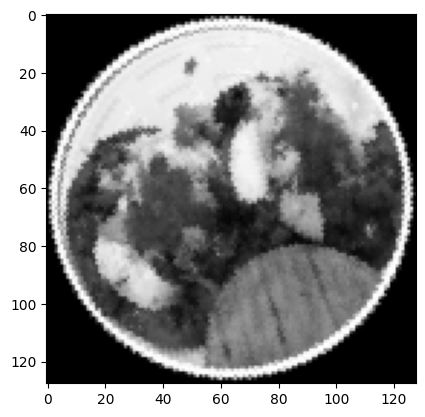

In [45]:
#random image
for img,l in train_dataloaders: #IMAGE,LABEL
  print(img[0].shape)

  plt.imshow(img[0].permute(1,2,0))
  break

In [18]:
device="cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [46]:
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights

In [15]:
weights = MobileNet_V2_Weights.DEFAULT
auto_transforms = weights.transforms()
auto_transforms


ImageClassification(
    crop_size=[224]
    resize_size=[232]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [16]:
# Create training and testing DataLoaders as well as get a list of class names
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=auto_transforms, # perform same data transforms on our own data as the pretrained model
                                                                               batch_size=32) # set mini-batch size to 32

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7e82190e6f50>,
 ['apple_pie',
  'baby_back_ribs',
  'baklava',
  'beef_carpaccio',
  'beef_tartare',
  'beet_salad',
  'beignets',
  'bibimbap',
  'bread_pudding',
  'breakfast_burrito',
  'bruschetta',
  'caesar_salad',
  'cannoli',
  'caprese_salad',
  'carrot_cake',
  'ceviche',
  'cheese_plate',
  'cheesecake',
  'chicken_curry',
  'chicken_quesadilla',
  'chicken_wings',
  'chocolate_cake',
  'chocolate_mousse',
  'churros',
  'clam_chowder',
  'club_sandwich',
  'crab_cakes',
  'creme_brulee',
  'croque_madame',
  'cup_cakes',
  'deviled_eggs',
  'donuts',
  'dumplings',
  'edamame',
  'eggs_benedict',
  'escargots',
  'falafel',
  'filet_mignon',
  'fish_and_chips',
  'foie_gras',
  'french_fries',
  'french_onion_soup',
  'french_toast',
  'fried_calamari',
  'fried_rice',
  'frozen_yogurt',
  'garlic_bread',
  'gnocchi',
  'greek_salad',
  'grilled_cheese_sandwich',
  'grilled_salmon',
  'guacamole',
  'gyoza',
  'hamburger',
  'ho

# Modeling

In [52]:
model = mobilenet_v2(weights=weights).to(device)
num_classes = 101
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)

# Print the modified model architecture
print(model)
summary(model.to(device), input_size=(3, 128, 128))


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [20]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
from timeit import default_timer as timer
start_timer=timer()
results=engine.train(model=model,
                     train_dataloader=train_dataloaders,
                     test_dataloader=test_dataloders,
                     optimizer=optimizer,
                     loss_fn=loss_fn,
                     epochs=5,
                     device=device)
end_timer=timer()
print(f"Total training time: {end_timer-start_timer:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.8444 | train_acc: 0.5251 | test_loss: 1.8715 | test_acc: 0.5238
Epoch: 2 | train_loss: 1.7590 | train_acc: 0.5435 | test_loss: 1.8254 | test_acc: 0.5342
Epoch: 3 | train_loss: 1.6878 | train_acc: 0.5586 | test_loss: 1.8366 | test_acc: 0.5355
Epoch: 4 | train_loss: 1.6374 | train_acc: 0.5693 | test_loss: 1.8398 | test_acc: 0.5333
Epoch: 5 | train_loss: 1.5801 | train_acc: 0.5835 | test_loss: 1.7936 | test_acc: 0.5453
Total training time: 2463.955 seconds


In [20]:
torch.save(model.state_dict(),"continue_fine_tuning.pth")

In [54]:
model.load_state_dict(torch.load('continue_fine_tuning.pth'))

<ipython-input-54-a245d3fc26de>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('continue_fine_tuning.pth'))


<All keys matched successfully>

In [23]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
from timeit import default_timer as timer
start_timer=timer()
results=engine.train(model=model,
                     train_dataloader=train_dataloaders,
                     test_dataloader=test_dataloders,
                     optimizer=optimizer,
                     loss_fn=loss_fn,
                     epochs=5,
                     device=device)
end_timer=timer()
print(f"Total training time: {end_timer-start_timer:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.5370 | train_acc: 0.5933 | test_loss: 1.7835 | test_acc: 0.5483
Epoch: 2 | train_loss: 1.4893 | train_acc: 0.6024 | test_loss: 1.7832 | test_acc: 0.5526
Epoch: 3 | train_loss: 1.4443 | train_acc: 0.6120 | test_loss: 1.7607 | test_acc: 0.5589
Epoch: 4 | train_loss: 1.4006 | train_acc: 0.6221 | test_loss: 1.7544 | test_acc: 0.5594
Epoch: 5 | train_loss: 1.3650 | train_acc: 0.6298 | test_loss: 1.7555 | test_acc: 0.5656
Total training time: 2379.600 seconds


In [24]:
def digits_2_class(x):
  for idx,i in enumerate(class_names):
    if x==idx:
      return i

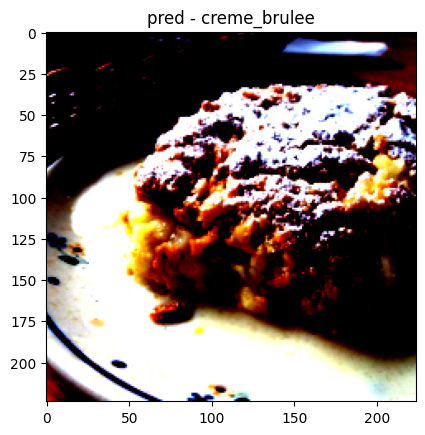

In [68]:
model.eval()
with torch.no_grad():
    for i, data in enumerate(test_dataloader):
        images, labels = data[0].to(device), data[1].to(device)

        outputs = model(images)
        lab_out=digits_2_class(outputs[0].argmax())
        plt.title(f'pred - {digits_2_class(outputs[0].argmax())}')
        plt.imshow(images[30].cpu().permute(1, 2, 0), cmap='gray')
        plt.show()
        break

In [74]:
print(f"The food predicted form the image is:- {lab_out}")

The food predicted form the image is:- creme_brulee


#Finding Calories & other info of pred food

In [70]:
import google.generativeai as genai
from api1 import api_key
genai.configure(api_key=api_key)
model1=genai.GenerativeModel("gemini-1.5-flash")
calories=model1.generate_content(f"give me the calories content of {lab_out} in less than 30 words.") #extracting the calories of the food
others=model1.generate_content(f"give me the dietary intake of {lab_out} and make informed food choices in less than 30 words. ")# extracting other info regarding food

In [71]:
r1=calories.text
r2=others.text
print(r1)
print(r2)

A typical serving of crème brûlée (about 1/2 cup) contains around 300-400 calories. 

Crème brûlée is high in sugar, fat, and calories. Choose this dessert occasionally and balance it with healthy meals and snacks. 

